# Importing Libraries

In [265]:
import os 
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
import xgboost
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima_model import ARIMA
import string
from textblob import TextBlob
from sklearn.model_selection import train_test_split

In [201]:
ps = PorterStemmer()

In [202]:
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KAUSHAL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\KAUSHAL\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Numerical Analysis

Importing Data From Yahoo Finance of sensex

In [203]:
import yfinance as yf
dfstk = yf.Ticker('^BSESN')
dfstk = dfstk.history(period="max")

In [204]:
dfstk.shape

(6307, 7)

In [205]:
dfstk.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1997-07-01 00:00:00+05:30,4263.109863,4301.770020,4247.660156,4300.859863,0,0.0,0.0
1997-07-02 00:00:00+05:30,4302.959961,4395.310059,4295.399902,4333.899902,0,0.0,0.0
1997-07-03 00:00:00+05:30,4335.790039,4393.290039,4299.970215,4323.459961,0,0.0,0.0
1997-07-04 00:00:00+05:30,4332.700195,4347.589844,4300.580078,4323.819824,0,0.0,0.0
1997-07-07 00:00:00+05:30,4326.810059,4391.009766,4289.490234,4291.450195,0,0.0,0.0


In [206]:
dfstk.reset_index(level=0, inplace=True)
dfstk['Date'] = dfstk['Date'].dt.strftime('%Y-%m-%d')

In [207]:
dfstk['Date'] = pd.to_datetime(dfstk['Date'],format = '%Y-%m-%d')

In [208]:
dfstk = dfstk[dfstk['Date'] > pd.datetime(year=2014, month=12, day=31)]

In [209]:
dfstk.reset_index(drop=True,inplace=True)

In [210]:
dfstk.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,7400,0.0,0.0
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,9200,0.0,0.0
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,14100,0.0,0.0
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,12200,0.0,0.0
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,8200,0.0,0.0


Text(0, 0.5, 'Close')

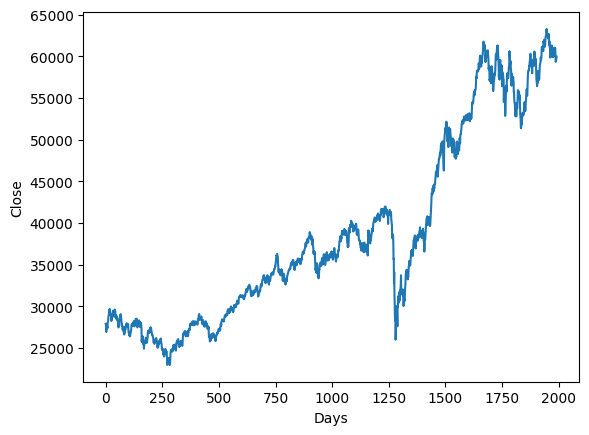

In [211]:
plt.plot(dfstk['Close'])
plt.xlabel('Days')
plt.ylabel('Close')

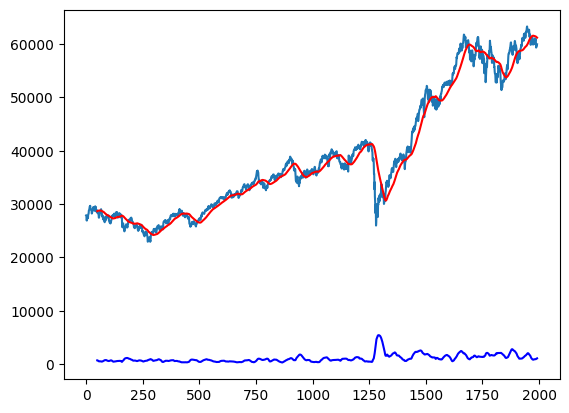

In [212]:
close = dfstk['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window=50).std()

plt.plot(dfstk['Close'])
plt.plot(ma, color='r')
plt.plot(std, color='b')

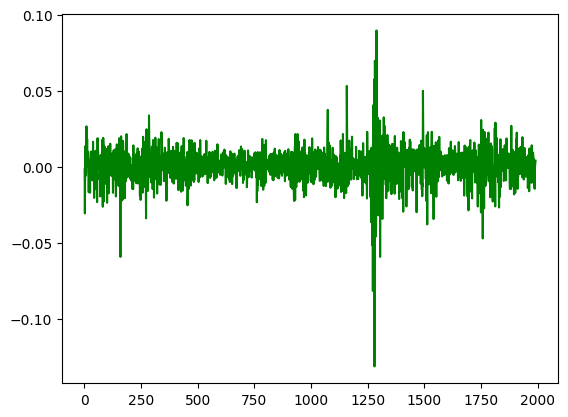

In [213]:
 returns = close / close.shift(1) - 1
    
plt.plot(returns, color='g')

In [214]:
train = dfstk.iloc[:-100]
test = dfstk.iloc[-100:]

In [215]:
train.shape

(1892, 8)

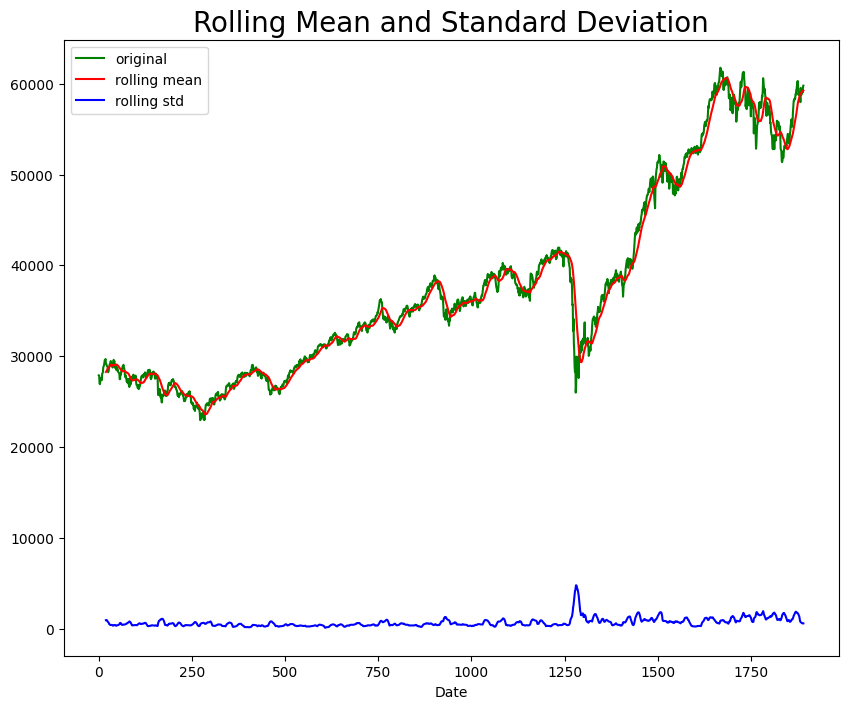

Dickey fuller test
ADF Test Statistic : -0.029135822460873272
p-value : 0.9560552184868013
#Lags Used : 7
Number of Observations Used : 1884
weak evidance against the null hypothesis, time series is non-stationary


In [216]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()
    
    plt.figure(figsize=(10,8))
    plt.plot(timeseries, color = 'g',label="original")
    plt.plot(rolmean, color = 'r',label="rolling mean")
    plt.plot(rolstd, color = 'b',label="rolling std")
    plt.xlabel('Date')
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation', fontsize=20)
    plt.show(block=False)
    
    print('Dickey fuller test')
    result = adfuller(timeseries, autolag = "AIC")
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for  vlaue,label in zip(result,labels):
        print(label+' : '+str(vlaue))
    if result[1] <= 0.05:
        print('Strong evidence againt the null  hypothesis(ho), reject hypothesis Data is stationary')
    else:
            print('weak evidance against the null hypothesis, time series is non-stationary')
test_stationarity(train['Close'])

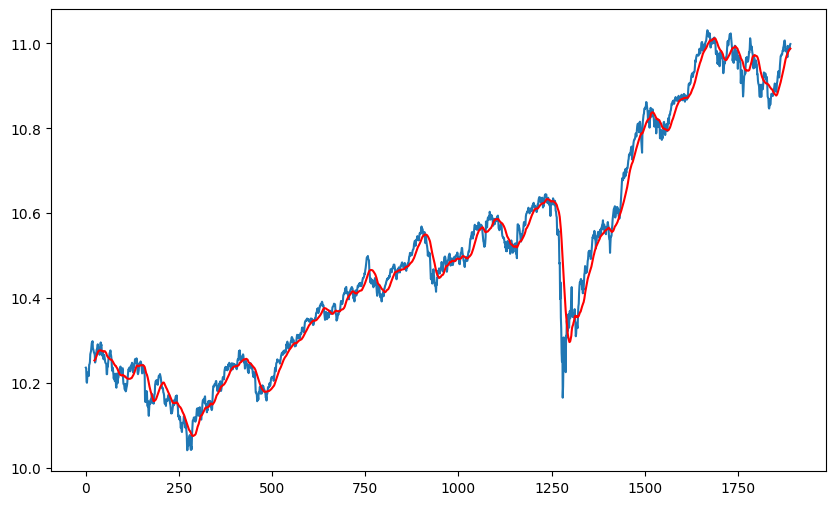

In [217]:
train_log = np.log(train['Close'])
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean()
plt.figure(figsize=(10,6))
plt.plot(train_log)
plt.plot(mav, color='r')

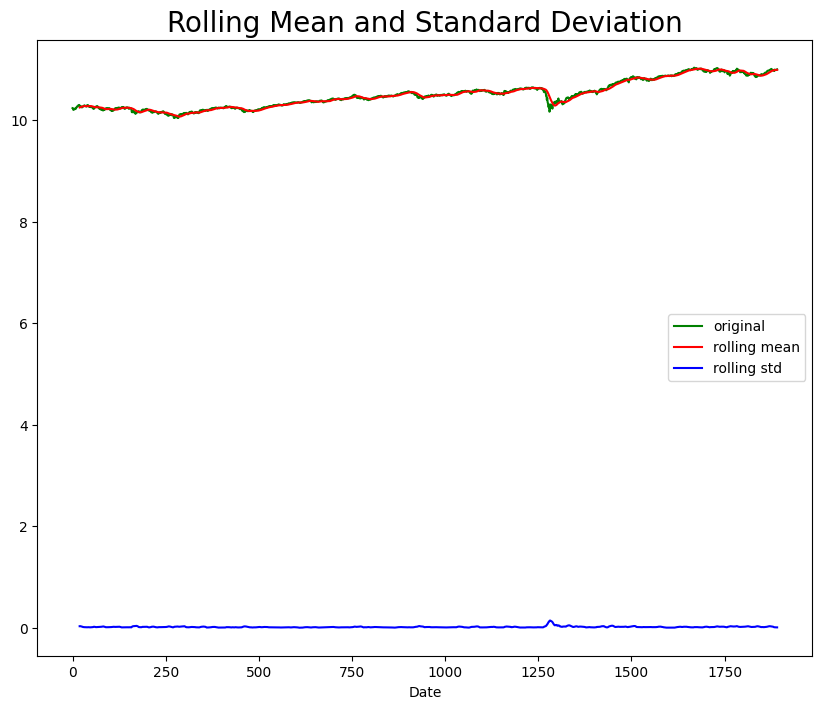

Dickey fuller test
ADF Test Statistic : -0.288705959172972
p-value : 0.92708874495924
#Lags Used : 12
Number of Observations Used : 1879
weak evidance against the null hypothesis, time series is non-stationary


In [218]:
train_log.dropna(inplace=True)
test_log.dropna(inplace=True)

test_stationarity(train_log)

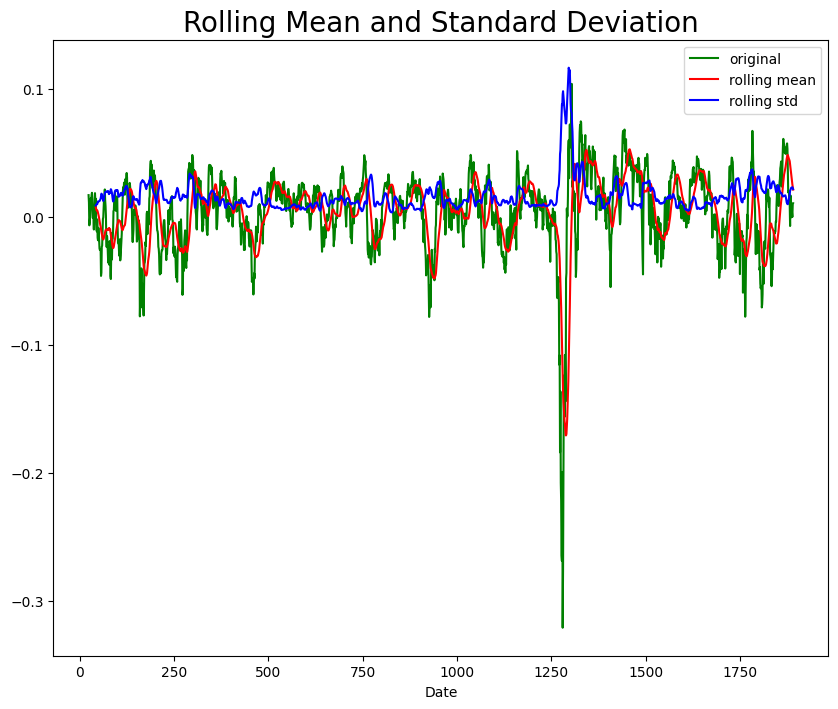

Dickey fuller test
ADF Test Statistic : -8.70247719907117
p-value : 3.776562278581517e-14
#Lags Used : 12
Number of Observations Used : 1856
Strong evidence againt the null  hypothesis(ho), reject hypothesis Data is stationary


In [219]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace=True)

test_stationarity(train_log_diff)

In [220]:
from pmdarima import auto_arima
model = auto_arima(train_log, trace=True, error_action='ignore',suppress_warnings=True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index=test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-11567.439, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11574.146, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11573.410, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11573.396, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11573.751, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11571.412, Time=0.34 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.312 seconds


Text(0, 0.5, 'Actual Stock Price')

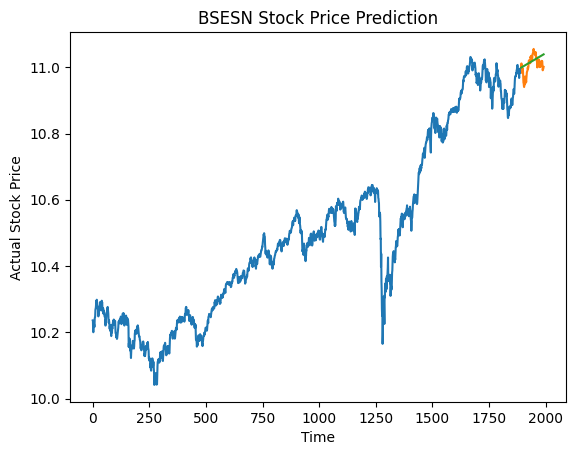

In [221]:
plt.plot(train_log, label='Train')
plt.plot(test_log,label='Test')
plt.plot(predictions,label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

In [222]:
rms = np.sqrt(mean_squared_error(test_log,predictions))
print('RMSE : ', rms)

RMSE :  0.026349688701021928


# Sentiment Analysis

Loading Dataset

In [223]:
cols = ['Date','Category','News']
df_news = pd.read_csv('india-news-headlines.csv', names = cols)

Preprocessing 

In [224]:
df_news.drop('Category',axis=1,inplace=True)

In [225]:
df_news.drop(0, inplace=True)

In [226]:
df_news['Date'] = pd.to_datetime(df_news['Date'],format = '%Y%m%d')

In [227]:
df_news = df_news[df_news['Date'] > pd.datetime(year=2014, month=12, day=31)]

In [228]:
df_news.head()

,Date,News
2039660,2015-01-01,Breakfast recipe for diabetics: Moong idlis
2039661,2015-01-01,Recipe: Delicious coconut balls
2039662,2015-01-01,Cure that dandruff naturally
2039663,2015-01-01,Recipe: Kerala Chicken curry
2039664,2015-01-01,Recipe: Mocha Coffee


In [229]:
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x))

In [230]:
df_news = df_news.drop_duplicates()

In [231]:
df_news.reset_index(drop=True,inplace=True)

In [232]:
df_news

,Date,News
0,2015-01-01,Breakfast recipe for diabetics: Moong idlis Re...
1,2015-01-02,Drink smart with these party tips How to say s...
2,2015-01-03,3 Stylish New Year cocktail recipes you'll LOV...
3,2015-01-04,How to get that bikini body Rules of love-maki...
4,2015-01-05,Recipe: Strawberry cupcakes Recipe: Kaju jeera...
...,...,...
2642,2022-03-27,Playing a dead man in Body God meant sitting i...
2643,2022-03-28,As fashion becomes democratic; demand for styl...
2644,2022-03-29,Bobby Deol: Like my dad; I hope to be working ...
2645,2022-03-30,I will not give in to trends: Dossmode The tim...


In [233]:
df_news['News'] = df_news['News'].str.replace('[^a-zA-Z]', ' ')

In [234]:
df_news['News'] = df_news['News'].apply(lambda x : x.lower())

In [235]:
tokenized = df_news['News'].apply(lambda x : x.split())

In [237]:
text = tokenized

0    [breakfast, recipe, for, diabetics, moong, idl...
1    [drink, smart, with, these, party, tips, how, ...
2    [stylish, new, year, cocktail, recipes, you, l...
3    [how, to, get, that, bikini, body, rules, of, ...
4    [recipe, strawberry, cupcakes, recipe, kaju, j...
Name: News, dtype: object

In [238]:
STOPWORDS = stopwords.words('english')
for i in range(len(tokenized)):
    text[i] =  ([word for word in tokenized[i] if word not in STOPWORDS])

In [240]:
text = text.apply(lambda x: [ps.stem(word) for word in x])

In [246]:
for i in range(len(text)):
    text[i] = " ".join(text[i])

In [247]:
text.head()

0    breakfast recip diabet moong idli recip delici...
1    drink smart parti tip say sorri kid take child...
2    stylish new year cocktail recip love dessert r...
3    get bikini bodi rule love make appli work bake...
4    recip strawberri cupcak recip kaju jeera rice ...
Name: News, dtype: object

In [248]:
df_news['News'] = text

In [249]:
df_news.head()

,Date,News
0,2015-01-01,breakfast recip diabet moong idli recip delici...
1,2015-01-02,drink smart parti tip say sorri kid take child...
2,2015-01-03,stylish new year cocktail recip love dessert r...
3,2015-01-04,get bikini bodi rule love make appli work bake...
4,2015-01-05,recip strawberri cupcak recip kaju jeera rice ...


Analysing Sentiment

In [251]:
def getsubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getpolarity(text):
    return TextBlob(text).sentiment.polarity

In [253]:
df_news['Subjectivity'] = df_news['News'].apply(getsubjectivity)
df_news['Polarity'] = df_news['News'].apply(getpolarity)
df_news.head()

,Date,News,Subjectivity,Polarity
0,2015-01-01,breakfast recip diabet moong idli recip delici...,0.432083,0.083989
1,2015-01-02,drink smart parti tip say sorri kid take child...,0.427002,0.059439
2,2015-01-03,stylish new year cocktail recip love dessert r...,0.412459,0.072817
3,2015-01-04,get bikini bodi rule love make appli work bake...,0.407143,0.089526
4,2015-01-05,recip strawberri cupcak recip kaju jeera rice ...,0.409543,0.119753


<AxesSubplot: >

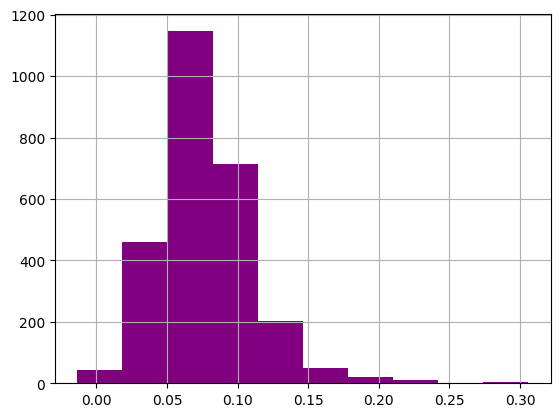

In [254]:
df_news['Polarity'].hist(color='purple')

<AxesSubplot: >

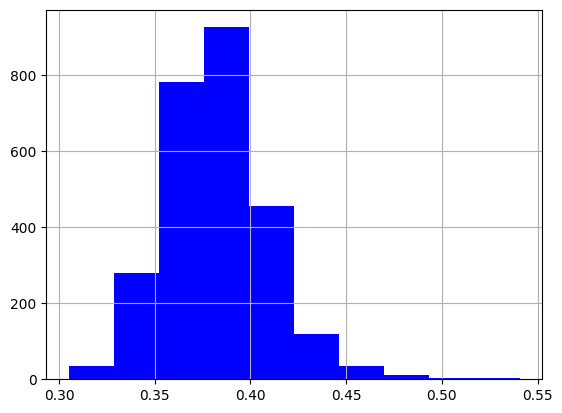

In [255]:
df_news['Subjectivity'].hist(color='b')

In [257]:
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2015-01-01,breakfast recip diabet moong idli recip delici...,0.432083,0.083989,-0.9991,0.118,0.792,0.091
1,2015-01-02,drink smart parti tip say sorri kid take child...,0.427002,0.059439,-0.9991,0.128,0.768,0.103
2,2015-01-03,stylish new year cocktail recip love dessert r...,0.412459,0.072817,-0.9996,0.127,0.787,0.086
3,2015-01-04,get bikini bodi rule love make appli work bake...,0.407143,0.089526,-0.9998,0.131,0.796,0.073
4,2015-01-05,recip strawberri cupcak recip kaju jeera rice ...,0.409543,0.119753,-0.9989,0.122,0.781,0.097
...,...,...,...,...,...,...,...,...
2642,2022-03-27,play dead man bodi god meant sit refriger guru...,0.356716,0.087855,-0.9999,0.149,0.782,0.069
2643,2022-03-28,fashion becom democrat demand stylist soar las...,0.382331,0.079270,-0.9998,0.144,0.778,0.078
2644,2022-03-29,bobbi deol like dad hope work age yasha surya ...,0.372864,0.083037,-0.9997,0.129,0.799,0.072
2645,2022-03-30,give trend dossmod time gave boyfriend incred ...,0.330696,0.052339,-0.9998,0.139,0.794,0.067


In [259]:
df_merge = pd.merge(dfstk,df_news,how='inner',on='Date')
df_merge.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,7400,0.0,0.0,drink smart parti tip say sorri kid take child...,0.427002,0.059439,-0.9991,0.128,0.768,0.103
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,9200,0.0,0.0,recip strawberri cupcak recip kaju jeera rice ...,0.409543,0.119753,-0.9989,0.122,0.781,0.097
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,14100,0.0,0.0,turn garden happi teeth jewelleri latest trend...,0.386223,0.046943,-0.9998,0.133,0.790,0.077
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,12200,0.0,0.0,ex lover friend water diet bad tip stay happi ...,0.386953,0.032975,-0.9999,0.154,0.766,0.081
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,8200,0.0,0.0,home manicur recip spice beetroot disinfect wa...,0.387770,0.076619,-0.9998,0.131,0.789,0.080


Merging both dataset

In [260]:
df = df_merge[['Close','Subjectivity','Polarity','Compound','Negative','Neutral','Positive']]
df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,27887.900391,0.427002,0.059439,-0.9991,0.128,0.768,0.103
1,27842.320312,0.409543,0.119753,-0.9989,0.122,0.781,0.097
2,26987.460938,0.386223,0.046943,-0.9998,0.133,0.790,0.077
3,26908.820312,0.386953,0.032975,-0.9999,0.154,0.766,0.081
4,27274.710938,0.387770,0.076619,-0.9998,0.131,0.789,0.080


scaling

In [261]:
from sklearn.preprocessing import MinMaxScaler
mc = MinMaxScaler()
new_df = pd.DataFrame(mc.fit_transform(df))
new_df.columns = df.columns
new_df.index = df.index
new_df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.127173,0.517779,0.228278,0.00045,0.435185,0.336134,0.543689
1,0.125999,0.443674,0.417200,0.00055,0.379630,0.445378,0.485437
2,0.103974,0.344693,0.189137,0.00010,0.481481,0.521008,0.291262
3,0.101948,0.347793,0.145385,0.00005,0.675926,0.319328,0.330097
4,0.111375,0.351261,0.282091,0.00010,0.462963,0.512605,0.320388


In [262]:
X = new_df.drop('Close',axis=1)
y = new_df['Close']

In [267]:
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=.3, random_state=0)

Model-Selection

In [273]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
predr = rf.predict(X_test)
mean_squared_error(predr,y_test)

0.03613044936613799

In [274]:
adb = AdaBoostRegressor()
adb.fit(X_train,y_train)
preda = adb.predict(X_test)
mean_squared_error(preda,y_test)

0.040006087998014285

In [276]:
xgb = xgboost.XGBRegressor()
xgb.fit(X_train,y_train)
predx = adb.predict(X_test)
mean_squared_error(predx,y_test)

0.040006087998014285

Hence we conclude that, RandomForestRegressor has highest accuracy 